<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [24]:
import pandas as pd

import numpy as np
import gensim
import os
import re

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [15]:
#Start Here
df = pd.read_csv('./Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [16]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [17]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

# Define the tokenize function
tokens = []

for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.lemma_.lower())
    tokens.append(doc_tokens)

df['tokens'] = tokens

In [18]:
id2word = corpora.Dictionary(df['tokens'])

In [19]:
print(len(id2word))

19476


In [20]:
id2word.filter_extremes(no_below=5, no_above=0.95)
print(len(id2word))

4883


In [21]:
corpus = [id2word.doc2bow(text) for text in df['tokens']]

In [25]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    for iter_ in range(passes):
        print(f"=== Pass {iter_ + 1} of {passes} ===")
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12, passes=5)
            print(f"Model with {num_topics} topics completed.")
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
        print('\n')
    return coherence_values

In [26]:
coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus,
                                            start=2, 
                                            limit=50, 
                                            step=2,
                                            passes=10)

=== Pass 1 of 10 ===
Model with 2 topics completed.
Model with 4 topics completed.
Model with 6 topics completed.
Model with 8 topics completed.
Model with 10 topics completed.
Model with 12 topics completed.
Model with 14 topics completed.
Model with 16 topics completed.
Model with 18 topics completed.
Model with 20 topics completed.
Model with 22 topics completed.
Model with 24 topics completed.
Model with 26 topics completed.
Model with 28 topics completed.
Model with 30 topics completed.
Model with 32 topics completed.
Model with 34 topics completed.
Model with 36 topics completed.
Model with 38 topics completed.
Model with 40 topics completed.
Model with 42 topics completed.
Model with 44 topics completed.
Model with 46 topics completed.
Model with 48 topics completed.


=== Pass 2 of 10 ===
Model with 2 topics completed.
Model with 4 topics completed.
Model with 6 topics completed.
Model with 8 topics completed.
Model with 10 topics completed.
Model with 12 topics completed.
Mode

In [28]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

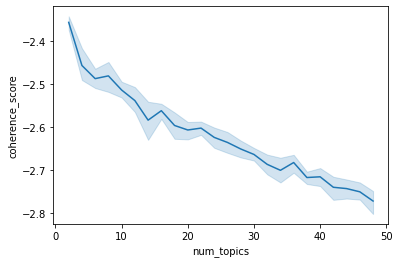

In [29]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [30]:
from gensim.models.ldamulticore import LdaMulticore

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 10,
                   passes=100,
                   workers=12
                  )

In [31]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
easy use use. set love

------ Topic 1 ------
great good product price buy

------ Topic 2 ------
love year old it. buy

------ Topic 3 ------
battery long good brand batteries.

------ Topic 4 ------
read book great play use

------ Topic 5 ------
kindle fire love new read

------ Topic 6 ------
work great works great. happy

------ Topic 7 ------
amazon app tablet google play

------ Topic 8 ------
tablet great good price. price

------ Topic 9 ------
charge buy good like use



In [32]:
distro = [lda[d] for d in corpus]
num_topics = 10
def update(doc):
        d_dist = {k:0 for k in range(0,num_topics)}
        for topic in doc:
            # Topic is Tuple where the first part is the topic id
            # the second part is the topic distribution in that doc
            d_dist[topic[0]] = topic[1]
        return d_dist
new_distro = [update(d) for d in distro]

In [33]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.232991  0.031742       1        1  23.039661
2      0.208121 -0.048385       2        1  12.797369
5      0.060061  0.185801       3        1  10.646886
7     -0.063949  0.120641       4        1  10.324718
1     -0.129905 -0.206704       5        1   8.265167
8     -0.056462 -0.104426       6        1   8.030422
0      0.227801 -0.059056       7        1   7.741757
4      0.061043  0.070358       8        1   7.158203
9     -0.071224  0.138859       9        1   6.975236
6     -0.002495 -0.128830      10        1   5.020582, topic_info=         Term         Freq        Total Category  logprob  loglift
3     battery  6913.000000  6913.000000  Default  30.0000  30.0000
35       easy  3088.000000  3088.000000  Default  29.0000  29.0000
92       love  5781.000000  5781.000000  Default  28.0000  28.0000
2669   kindle  2496.000000  2496.000000  Default  27.0000  27.0000
71      great  7538.000000  7538.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
31        buy   173.817856  4629.747559  Topic10  -4.5481  -0.2906
377      it's   131.170441  2202.657227  Topic10  -4.8296   0.1707
171      time   106.434784  1573.042236  Topic10  -5.0385   0.2984
182      nice    93.672836  1079.735596  Topic10  -5.1663   0.5470
97       want    88.517670  1141.204468  Topic10  -5.2229   0.4350

[751 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4203      6  0.928792  $100.
4015      6  0.954487    $50
450       1  0.089052      1
450       2  0.252315      1
450       4  0.089052      1
...     ...       ...    ...
152       9  0.054122   xbox
2410      2  0.984791   xmas
106       2  0.999683   year
1171     10  0.959958   yet,
3696      2  0.996630     yr

[1646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 8, 2, 9, 1, 5, 10, 7])

In [34]:
topics_df = pd.DataFrame(new_distro)
topics_df.columns = topics
topics_df.head()

,easy use use. set love,great good product price buy,love year old it. buy,battery long good brand batteries.,read book great play use,kindle fire love new read,work great works great. happy,amazon app tablet google play,tablet great good price. price,charge buy good like use
0,0.000000,0.000000,0.000000,0.702481,0.224728,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.016671,0.353335,0.016668,0.513303,0.016671,0.016670,0.016668,0.016672,0.016669,0.016673
2,0.025003,0.496055,0.025003,0.303916,0.025003,0.025003,0.025008,0.025003,0.025004,0.025003
3,0.016667,0.016675,0.016667,0.849976,0.016668,0.016669,0.016672,0.016668,0.016669,0.016668
4,0.016668,0.016672,0.016667,0.748476,0.016668,0.016668,0.118178,0.016667,0.016669,0.016668


In [35]:
topics_df['primaryTopic'] = topics_df.idxmax(axis=1)

In [36]:
topics_df['primaryTopic'].value_counts()

battery long good brand batteries.    7468
love year old it. buy                 4093
great good product price buy          3752
tablet great good price. price        2390
easy use use. set love                2132
kindle fire love new read             2126
amazon app tablet google play         1874
work great works great. happy         1628
read book great play use              1588
charge buy good like use              1281
Name: primaryTopic, dtype: int64

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling